# Mixture Density Networks - Hands On Tutorial
This notebook demonstrates the construction of a simple MDN, and compares it to a regular neural network.  
All code was tuned for Tensorflow v2 api, with comments.

Read about MDNs on the [original paper](https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) by C. Bishop.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

The network we'll construct will try to learn the following relation between $x$ and $f(x)$: 

$$f(x) = x^2-6x+9$$


Note that this simply $y = x^2$ shifted three steps to the left (global minimum is at $x=3$).

In [2]:
def f(x):
    return x**2-6*x+9 

In order to make the data a little bit more relaistic, we'll add a normally-distributed noise, which will be location-dependent - the larger $x$ is, the larger the noisier the data will be. So, our data generator will obey the following relation:

$$g(x) = f(x) + \epsilon(x) $$ 

$$ \text{where}: \epsilon(x) = N(0,\sigma_0 x)$$

Where $N(\mu,\sigma)$ is the normal distribution with mean $\mu$ and STD of $\sigma$.

The `data_generator` below function creates $n$ nosiy data samples for a given `x`, where $n$ is defined by `samples`. Notice that technically, `data_generator` yields $g(x) = N(f(x),\sigma_0 x)$, as mathematically that's the same thing. 

In [3]:
def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)

We'll now generate our dataset for $1<x<5$.

The purple line in the plot presents the "clean" function $f(x)$ for this range.

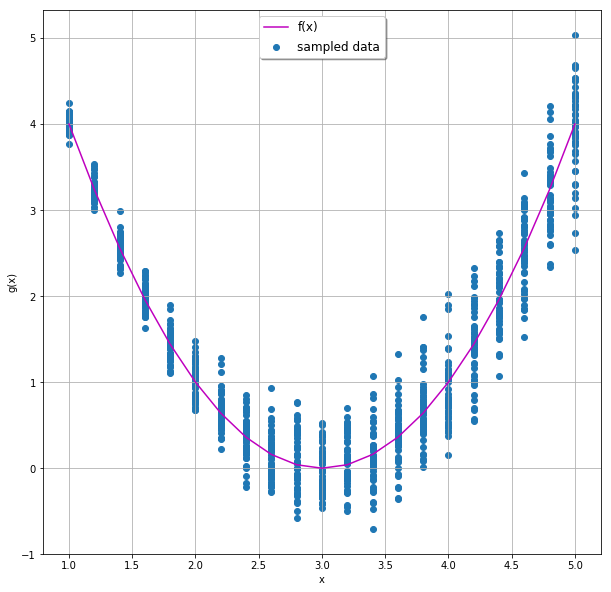

In [4]:
sigma_0 = 0.1
x_vals = np.arange(1,5.2,0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x,sigma_0,samples))
x_arr, y_arr = shuffle(x_arr, y_arr)
x_test = np.arange(1.1,5.1,0.2)

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
ax.scatter(x_arr,y_arr,label='sampled data')
# some versions of matplot dont support generators, so fix this adding list()
ax.plot(x_vals, list(map(f,x_vals)), c='m', label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## Regular neural network
We'll now train a neural network which will receive $x$ as input and our noisy $g(x)$ but will have to learn the relation $x \rightarrow f(x)$.

The network is constructed of two hidden layers, each with 12 nodes and the $\tanh(x)$ activation function (note we don't use any activation on the last output layer).

We set the learning rate $\alpha=0.0003$, 50 examples per mini-batch and a total of 500 epoches.

In [5]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr)/batch_size)

# set default dtypes for values created by keras backend
tf.keras.backend.set_floatx('float64')

# V2 api support model oriented networks. We need to define tensor variables as inputs for model
x = tf.keras.layers.Input(shape=(1))

# also layers is migrated into keras.layers
layer = x
for _ in range(3):
    layer = tf.keras.layers.Dense(units=12, activation=tf.nn.tanh)(layer)
output = tf.keras.layers.Dense(units=1)(layer)

# we will use cost as part of training step
#cost = tf.reduce_mean(tf.losses.mean_squared_error(y, output))
# also minimize function migrates to apply_gradients during training step
optimizer = tf.optimizers.Adam(learning_rate)#.minimize(cost)

x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)

# compile and show network information
model = tf.keras.Model(inputs=x, outputs=output)
model.summary()

# this is new way of eager functions. Now we use this functions instead of sessions
@tf.function
def train_step(inputs, y):
    with tf.GradientTape() as tape:
        pred = model(inputs, training=True)
        pred_loss = tf.reduce_mean(tf.losses.mean_squared_error(y, pred))
        total_loss = pred_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss

for epoch in range(epochs):
    x_batches, y_batches = shuffle(x_batches, y_batches)
    for i in range(batch_num):
        x_batch = np.expand_dims(x_batches[i],axis=1)
        y_batch = np.expand_dims(y_batches[i],axis=1)
        loss = train_step(x_batch, y_batch)
    if epoch % display_step == 0:
        print('Epoch {0} | cost = {1:.4f}'.format(epoch,loss))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 349
Trainable params: 349
Non-trainable params: 0
_________________________________________________________________
Epoch 0 | cost = 3.1834
Epoch 50 | cost = 1.6081
Epoch 100 | cost = 0.5790
Epoch 150 | cost = 0.1602
Epoch 200 | cost = 0.0853
Ep

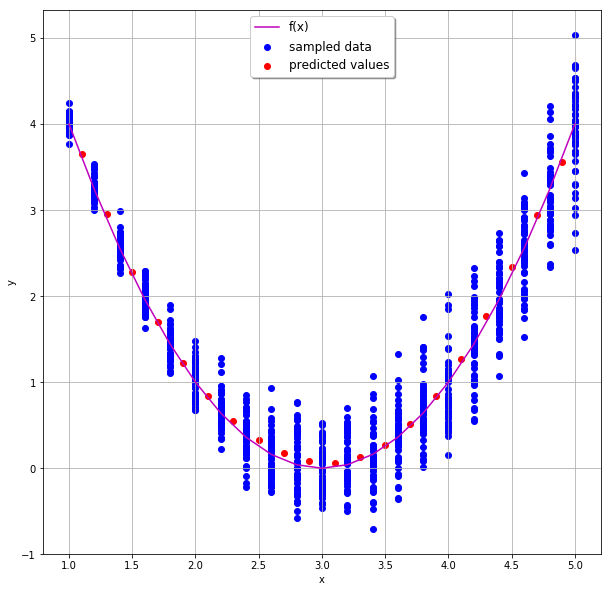

In [6]:
# getting prediction from network
y_pred = model(np.expand_dims(x_test,axis=1),training=False).numpy().squeeze()

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr, y_arr,c='b', label='sampled data')
ax.scatter(x_test, y_pred,c='r', label='predicted values')
ax.plot(x_vals, list(map(f,x_vals)), c='m', label='f(x)')
ax.legend(loc='upper center', fontsize='large', shadow=True)
plt.show()

It seems to be doing quite good in predicting $f(x)$, but we can clearly see that the network learnt nothing about the size of the noise. 

## Mixture density network (MDN)
Let's try an MDN now. We'll use the same network as in the previous section, with one important change:
the output layer now has two nodes (which are constructed as two layers of 1 node for technical simplicity), which we named `mu` and `sigma`

Note the new cost function: we create a normal distribution out of the predicted `mu` and `sigma`, and then minimize the negative log-likelihood of this distribution yielding the traget value `y`. Mathematically, our cost function is the negative logarithm of the normal distribution's probability density function (PDF):

$$Cost = -\log (PDF) = -\log\left(\frac{1}{\sqrt{2\pi\sigma}}\cdot\exp{\left[-\frac{(y-\mu)^{2}}{2\sigma^{2}}\right]}\right)$$

In [7]:
# probability distributions now migrated into seperated module
import tensorflow_probability as tfp

def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    # This is small hack. For now session run now changed into direct function parsing by eager
    # for some reasons eager converts non-tensor y values into tf.fload32 dtype 
    # this cased errors, so I've casted back to float64 value manually
    yt = tf.cast(y, tf.float64)
    return tf.reduce_mean(-dist.log_prob(yt))

We'll use `elu + 1` as the activation function for `sigma`, as it must always be non-negative. The Exponential Linear Unit (ELU) is defined as:

$$ ELU(x) = \begin{cases} x & x\ge0 \\ \exp{(x)}-1 & x < 0 \end{cases} $$

In [8]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr) / batch_size)

x = tf.keras.layers.Input(shape=(1))

layer = x
for _ in range(3):
    layer = tf.keras.layers.Dense(units=12, activation=tf.nn.tanh)(layer)

# we use keras multi output models
mu = tf.keras.layers.Dense(1)(layer)
sigma = tf.keras.layers.Dense(1, activation=lambda x: tf.nn.elu(x)+1)(layer)

optimizer = tf.optimizers.Adam(learning_rate)

x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)

# this is important notice, keras models has fit function
# we could use it in previous model and everything will work fine
# but in second example we want to calculate custom loss for different 
# shapes, loss([mu, sigma], y). Keras fit expects to see same shapes for y and predictions 
model = tf.keras.Model(inputs=x, outputs=[mu, sigma])
model.summary()
    
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        mu, sigma = model(inputs, training=True)
        pred_loss = mdn_cost(mu, sigma, labels)
        total_loss = pred_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss

for epoch in range(epochs):
    x_batches, y_batches = shuffle(x_batches, y_batches)
    for i in range(batch_num):
        x_batch = np.expand_dims(x_batches[i],axis=1)
        y_batch = np.expand_dims(y_batches[i],axis=1)
        loss = train_step(x_batch, y_batch)
        
    if epoch % display_step == 0:
        print('Epoch {0} | cost = {1:.4f}'.format(epoch,loss))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 12)           24          input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 12)           156         dense_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 12)           156         dense_5[0][0]                    
____________________________________________________________________________________________

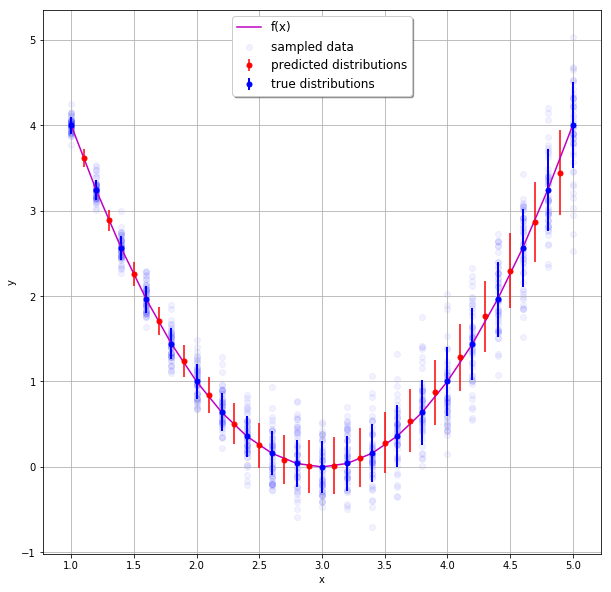

In [9]:
mu_pred, sigma_pred = model(np.expand_dims(x_test,axis=1),training=False)

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(x_test,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals, list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
ax.plot(x_vals, list(map(f,x_vals)), c='m', label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

The plot above shows the results learnt by the network. In red are the networks predictions for $\mu$ and $\sigma$, and in blue are the actual $\mu$ and $\sigma$ used for the training set. The actual data can be seen faded in the background. We can clearly see the network has learnt not just $x \rightarrow f(x)$, but also the noise creating $x \rightarrow g(x)$.